<a href="https://colab.research.google.com/github/MatchLab-Imperial/deep-learning-course/blob/master/week06_part2_Autoencoders_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Representation Learning: Autoencoders
As seen in the previous tutorial, the aim of an autoencoder is to learn a function that reduces the dimensionality of the input data, only characterizing the most discriminative information from it.  Autoencoders learn a representation of a set of data in an unsupervised manner, from which they will be able to generate a new representation as close as possible to the original input.

The idea is that they use the reconstruction error on input data as a form of “self”-supervision. They create a feature representation (encoding), and a decoding function to reconstruct the input data.

This dimensionality reduction/compression is widely used in many signal processing tasks. We will focus this tutorial on using autoencoders to deal with noise in images as it is the first step of the baseline code of the [course coursework](https://github.com/MatchLab-Imperial/keras_triplet_descriptor).

# Dealing with Noise
Ideally, we would like to capture only the key aspects presented in the data but ignore noise/nuances. Therefore, an efficient encoding should automatically ignore the noise. The idea behind is that noise is random, and it can not be predicted, a robust encoding/decoding will learn to identify the stable patterns within the image and avoid the non-smooth perturbations produced by the noise. 

This idea is in line with the** Efficient Coding Hypothesis** from the neuroscience of vision, which says ". . . the Efficient Coding Hypothesis holds that the purpose of early visualprocessing is to produce an efficient representation of the incoming visual signal."

Noise can presented in many different ways, such as additive or multiplicative. We will generate synthetically additive Gaussian noise in order to show you how to train a denoising autoencoder. 



We use numpy to add the noise to input images:

In [0]:
import numpy as np
import keras
from keras.datasets import cifar100
from keras.utils import to_categorical

# Load the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

num_classes = 100
y_train=to_categorical(y_train,num_classes)
y_test=to_categorical(y_test,num_classes) 

# Add noise
x_train_noise = x_train + np.random.normal(size = x_train.shape, scale = 0.1)
x_test_noise = x_test + np.random.normal(size = x_test.shape, scale = 0.1)

We can visualize some examples to have an idea of how the noise looks like:

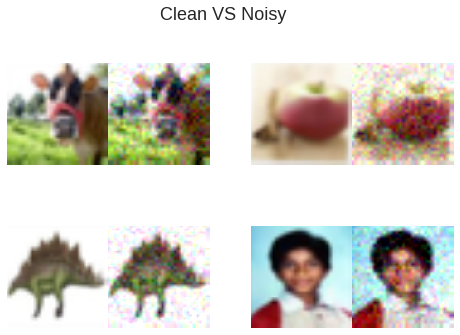

In [0]:
import matplotlib.pyplot as plt
from keras.layers import Lambda, Input
from keras.models import Model
from keras.backend import tf as ktf

# Resize images for better visualization
inp = Input(shape=(32, 32, 3))
out = Lambda(lambda image: ktf.image.resize_images(image, (224, 224)))(inp)

model = Model(inputs=inp, outputs=out)
x_train_resized = model.predict(x_train[:4, ...])
x_train_noise_resized = model.predict(x_train_noise[:4, ...])

N=2
start_val = 0
fig, axes = plt.subplots(N,N)
plt.suptitle('Clean VS Noisy', fontsize=18)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    
    im = np.concatenate((x_train_resized[idx], x_train_noise_resized[idx]), 1)
    axes[row,col].imshow(np.clip(im, 0, 1))
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

# Linear Autoencoders

As in regular architecture design, when defining the structure of an autoencoder, we can decide the number of convolutional layers, dense layers, normalization mechanisms, activation functions, and so on. 

Firstly, we will start with a simple linear architecture to show a straightforward case scenario, and then, we will build on top more complete and complex algorithms.

In [0]:
from keras.layers import Dense, Reshape, Flatten
from keras.models import Sequential

model = Sequential()

## Encoder starts
model.add(Flatten())
model.add(Dense(128, input_shape=(32*32*3,)))
model.add(Dense(30))

## And now the decoder
model.add(Dense(128))
model.add(Dense(32*32*3))
model.add(Reshape((32, 32, 3)))


We can train our model with standard Mean Square Error (MSE) loss function. MSE is computed between reconstructed images and noisy ones. Ideally, the noise will not be model, and the architecture will be only able to reconstruct the structure of the noisy image, avoiding the noise.

Sometimes we have noisy and clean images, and we can compute the MSE between the reconstructed and the clean ones. Normally, using clean GT images improves results unlike when only using noisy ones. However, we will start from the perspective of image compression and feature representation, and train our denoising model using exclusively noisy images.

In [0]:
model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mse'])
model.fit(x_train_noise, x_train_noise, batch_size=128, epochs=10, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 8s 186us/step - loss: 0.0522 - mean_squared_error: 0.0522 - val_loss: 0.0317 - val_mean_squared_error: 0.0317
Epoch 2/10
45000/45000 [==============================] - 4s 89us/step - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.0262 - val_mean_squared_error: 0.0262
Epoch 3/10
45000/45000 [==============================] - 4s 90us/step - loss: 0.0251 - mean_squared_error: 0.0251 - val_loss: 0.0244 - val_mean_squared_error: 0.0244
Epoch 4/10
45000/45000 [==============================] - 4s 90us/step - loss: 0.0240 - mean_squared_error: 0.0240 - val_loss: 0.0238 - val_mean_squared_error: 0.0238
Epoch 5/10
45000/45000 [==============================] - 4s 89us/step - loss: 0.0237 - mean_squared_error: 0.0237 - val_loss: 0.0238 - val_mean_squared_error: 0.0238
Epoch 6/10
45000/45000 [==============================] - 4s 89us/step - loss: 0.0236 - mean_squared_error: 0.0236 

Let's check how images look like after 10 epochs. Run the following code as many times as desired to see different examples:

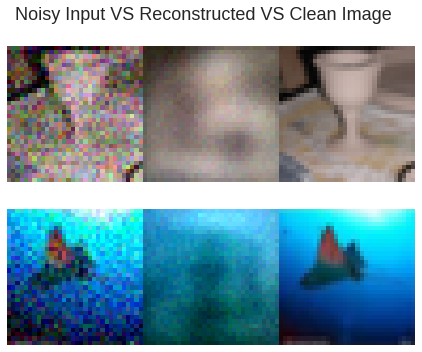

In [0]:
idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Reconstructed VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col
    
    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

Reconstructed images are a blurred version of the clean ones. The proposed autoencoder is able to learn to remove noise, but results are far from being perfect when comparing with the GT images. However, it is promising that with a few neurons, the network is able to generate images that have the same color and shape than original ones.

Now, you can try to built a **Deep Autoencoder**, e.g., add more dense layers or more neurons, and check if you are able to improve results. 

In [0]:
deeper_model = Sequential()

## First encoder's layer
deeper_model.add(Flatten())


# Define here your model 

# . . .


## Last decoder's layer
deeper_model.add(Dense(32*32*3))
deeper_model.add(Reshape((32, 32, 3)))

# Non-linear Autoencoders

In non-linear autoencoders, we introduce non-linearities within the network by using non-linear activation functions. This is a big difference with classical technique PCA, where it only could perform a linear transformation of the data. Therefore, by using non-linear autoencoders we can create flexible algorithms that can learn features/relationships in the data beyond linear transformations. 

Now, we will check if adding a non-linear activation function brings any improvement: 

In [0]:
from keras.layers import Activation

nonlinear_model = Sequential()

## Encoder starts
nonlinear_model.add(Flatten())
nonlinear_model.add(Dense(128, input_shape=(32*32*3,)))
nonlinear_model.add(Dense(30))

## And now the decoder
nonlinear_model.add(Dense(128))
nonlinear_model.add(Dense(32*32*3, activation='sigmoid'))
nonlinear_model.add(Reshape((32, 32, 3)))

nonlinear_model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mse'])
nonlinear_model.fit(x_train_noise, x_train_noise, batch_size=128, epochs=10, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 7s 158us/step - loss: 0.0430 - mean_squared_error: 0.0430 - val_loss: 0.0272 - val_mean_squared_error: 0.0272
Epoch 2/10
45000/45000 [==============================] - 4s 85us/step - loss: 0.0252 - mean_squared_error: 0.0252 - val_loss: 0.0241 - val_mean_squared_error: 0.0241
Epoch 3/10
45000/45000 [==============================] - 4s 85us/step - loss: 0.0237 - mean_squared_error: 0.0237 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 4/10
45000/45000 [==============================] - 4s 85us/step - loss: 0.0234 - mean_squared_error: 0.0234 - val_loss: 0.0234 - val_mean_squared_error: 0.0234
Epoch 5/10
45000/45000 [==============================] - 4s 84us/step - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.0233 - val_mean_squared_error: 0.0233
Epoch 6/10
45000/45000 [==============================] - 4s 85us/step - loss: 0.0233 - mean_squared_error: 0.0233 

We can now visualize the reconstructed images by the new non-linear model. 

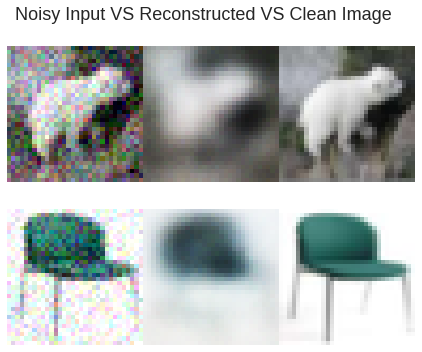

In [0]:
idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = nonlinear_model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Reconstructed VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col
    
    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

Comparing qualitatively results at this stage is hard, therefore, we can compute the MSE metric in the test set for both architectures:

In [0]:

mse_linear, _ = model.evaluate(x_test_noise, x_test)
mse_nonlinear, _ = nonlinear_model.evaluate(x_test_noise, x_test)

print('MSE Linear Model:', mse_linear)
print('MSE Non-linear Model:', mse_nonlinear)

10000/10000 [==============================] - 1s 116us/step
MSE Linear Model: 0.01737069298028946
MSE Non-linear Model: 0.013622927388548851


Although results are close, we can observe an improvement on MSE just by applying a non-linear activation function to the network.

# Convolutional Autoencoders

As seen in previous tutorials, 2D convolutions are more suitable when the input is an image than 1D convolutions. In practical settings, images are always applied to convolutional autoencoders, they simply perform much better. 

CNNs are used exactly as before, however, now we have to take into account elements such as strides, pooling, upsamplings, deconvolutions, which will control the size (width and length) of the generated feature maps. 

In addition, we need to define the number of levels of compression within the architecture, which can control done by limiting the number of convolutional layers and downsampling steps:


![](https://i.ibb.co/vB2jq4C/autoencoders.png)


In [0]:
from keras.layers import UpSampling2D, Conv2D

CNN_model = Sequential()

## Encoder starts
CNN_model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
CNN_model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
CNN_model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))

# At this point the dimension of the feature map is (batch_size, 4, 4, 128)

## And now the decoder
CNN_model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
CNN_model.add(UpSampling2D((2, 2)))
CNN_model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
CNN_model.add(UpSampling2D((2, 2)))
CNN_model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu'))
CNN_model.add(UpSampling2D((2, 2)))

# Improve smoothness of the image:
CNN_model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu'))

CNN_model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mse'])
CNN_model.fit(x_train_noise, x_train_noise, batch_size=128, epochs=10, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 13s 300us/step - loss: 0.0439 - mean_squared_error: 0.0439 - val_loss: 0.0284 - val_mean_squared_error: 0.0284
Epoch 2/10
45000/45000 [==============================] - 10s 220us/step - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0222 - val_mean_squared_error: 0.0222
Epoch 3/10
45000/45000 [==============================] - 10s 217us/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0177 - val_mean_squared_error: 0.0177
Epoch 4/10
45000/45000 [==============================] - 10s 215us/step - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0165 - val_mean_squared_error: 0.0165
Epoch 5/10
45000/45000 [==============================] - 10s 215us/step - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0157 - val_mean_squared_error: 0.0157
Epoch 6/10
45000/45000 [==============================] - 10s 214us/step - loss: 0.0159 - mean_squared_err

In our example, we used in the encoder part strides of (2, 2), which will downsample the dimension of the feature map by 2 at every step. While in the decoder, we use UpSampling2D layers to increase at each level the feature's dimension by 2. This two mechanism allows us to control the dimensions of the feature maps, as, in the end, input and output must have the same shape. 

Let's check how reconstructed images look:

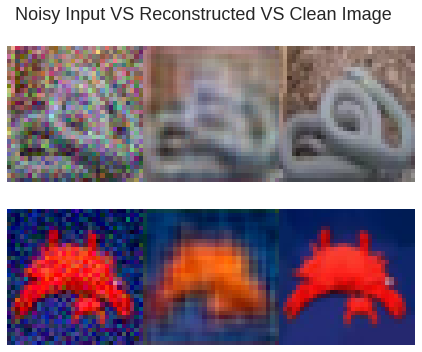

In [0]:
idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = CNN_model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0 
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Reconstructed VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col
    
    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

Images look better now. However, they are still far from perfect. You can try to add more layers, filters, activation functions, or even, increase the levels of compression within architecture and see how you can improve results. 


# Denoising with Clean Images

Autoencoders have been used for cleaning images, as they are able to encode the information structure and recover the image while ignoring the non-smooth perturbations produced by the noise. So far, we have presented a "self"-supervise manner to train an autoencoder, since the loss function is computed between the reconstructed image and a noisy image. 

Although having a ground-truth of clean images is not always possible, it is desirable when training denoise models since leads to better performances. Many people have been working on generating datasets with clean and noise paired images in order to train better denoising models. Ideally, when comparing performances of denoising methods, we use a dataset with corresponding pairs of noisy and clean version images. 

As we have generated synthetically the noise, we can train the network using the original image as the clean one:

In [0]:
CNN_gt_model = Sequential()

## Encoder starts
CNN_gt_model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
CNN_gt_model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
CNN_gt_model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))

# At this point the dimension of the feature map is (batch_size, 4, 4, 128)

## And now the decoder
CNN_gt_model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
CNN_gt_model.add(UpSampling2D((2, 2)))
CNN_gt_model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
CNN_gt_model.add(UpSampling2D((2, 2)))
CNN_gt_model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu'))
CNN_gt_model.add(UpSampling2D((2, 2)))

# Improve smoothness of the image:
CNN_gt_model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu'))

CNN_gt_model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mse'])
CNN_gt_model.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 14s 316us/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 2/10
45000/45000 [==============================] - 11s 235us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 3/10
45000/45000 [==============================] - 11s 234us/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 4/10
45000/45000 [==============================] - 11s 234us/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 5/10
45000/45000 [==============================] - 11s 234us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 6/10
45000/45000 [==============================] - 11s 234us/step - loss: 0.0067 - mean_squared_err

Let's now check how reconstructed images look:

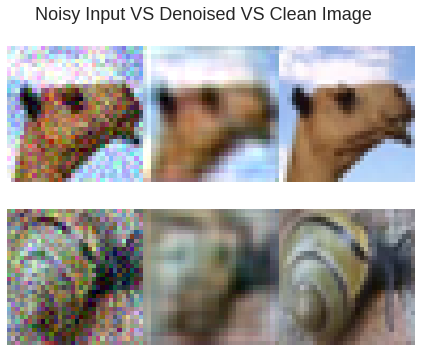

In [0]:
idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = CNN_gt_model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0 
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Denoised VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col
    
    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

In addition, we can compare the MSE when having clean images for training or not:

In [0]:
mse_selfsupervised, _ = CNN_model.evaluate(x_test_noise, x_test)
mse_supervised, _ = CNN_gt_model.evaluate(x_test_noise, x_test)

print('MSE "Self"-supervised Model. Trained only with Noisy Images: ', mse_selfsupervised)
print('MSE Supervised Model. Trained also with Clean Images: ', mse_supervised)

10000/10000 [==============================] - 2s 162us/step
MSE "Self"-supervised Model. Trained only with Noisy Images:  0.00620240020006895
MSE Supervised Model. Trained also with Clean Images:  0.005818749139457941


At this point, results do not differ that much. Model's complexity is not enough to reconstruct properly the image, and then having the clean image does not have a big impact. However, when using more complex models, which are able to recover the image, the fact that we can use clean images for training will help us to obtain much higher quality denoised images.

In October 2018, Nvidia's paper [Noise2Noise](https://arxiv.org/pdf/1803.04189.pdf) introduced a method that learned to restore images without ever observing clean ones, at performance close or equal to training using clean exemplars. They demonstrated that they could substitute classical clean and noisy pairs of images by "infinite" corrupted ones, and still be able to clean images even though they did not use any clean one for training. It is worth having a look at it. 

# Robust Autoencoders

Another approach to improve the robustness of the representation created by autoencoders is to replace the quadratic error with a loss function that is more robust to outliers. For instance, we could use Mean Absolute Error (MAE) instead of MSE. 

Let's define the architecture:

In [0]:
def define_model():
  
  model = Sequential()

  ## Encoder starts
  model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
  model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))

  # At this point the dimension of the feature map is (batch_size, 4, 4, 128)

  ## And now the decoder
  model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu'))
  model.add(UpSampling2D((2, 2)))

  # Improve smoothness of the image:
  model.add(Conv2D(filters=3, kernel_size=(3,3), padding='same', activation='relu'))
  
  return model

We can compare results when using MSE and MAE as loss functions:

In [0]:
model_mse = define_model()
model_mse.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mse'])
model_mse.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1)

_, mse_mse = model_mse.evaluate(x_test_noise, x_test)

model_mae = define_model()
model_mae.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mse'])
model_mae.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1)

_, mse_mae = model_mae.evaluate(x_test_noise, x_test)

print('MSE (trained with MSE as loss): ', mse_mse)
print('MSE (trained with MAE as loss): ', mse_mae)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 14s 319us/step - loss: 0.0502 - mean_squared_error: 0.0502 - val_loss: 0.0157 - val_mean_squared_error: 0.0157
Epoch 2/10
45000/45000 [==============================] - 11s 235us/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 3/10
45000/45000 [==============================] - 11s 234us/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 4/10
45000/45000 [==============================] - 11s 234us/step - loss: 0.0092 - mean_squared_error: 0.0092 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 5/10
45000/45000 [==============================] - 11s 234us/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 6/10
45000/45000 [==============================] - 11s 234us/step - loss: 0.0081 - mean_squared_err

Finally, we can compare qualitative results when using different loss functions:

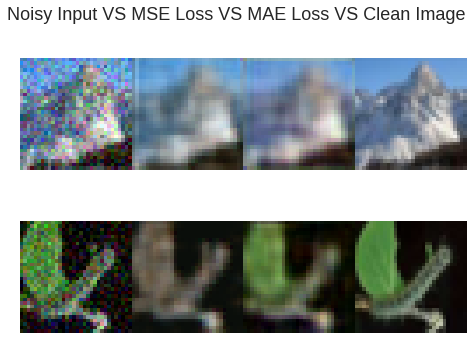

In [0]:
idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised_mse = model_mse.predict(x_test_noise[idx_example:idx_example+2, ...])
x_test_denoised_mae = model_mae.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0 
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS MSE Loss VS MAE Loss VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col
    
    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised_mse[idx], 
                         x_test_denoised_mae[idx], x_test[idx_example+idx]), 1)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

When using MAE as loss function both quantitative and qualitative results are better!

# Use Custom Loss Functions in Keras

Sometimes, you need to use a loss function that is not defined in Keras. If that happens, you can define it by yourself and use it into the model.compile module. 

You must define some variables:

* **True values** are those that we are aiming to generate, e.g. GT images.
* **Predicted values** are those that the network has generated,  e.g. denoised images.
* **Loss value** is the computed loss between true and predicted values,  e.g. MSE value.

Let's see an example of how to define a custom loss function:

In [0]:
def custom_loss(true_values, predicted_values):
  
  loss_value = 0
  
  #     ...    

  #     Define here your loss

  #     ...
    
  return loss_value

 Now, an example of how to code MSE loss function:

In [0]:
from keras import backend as K

def custom_loss(true_values, predicted_values):
    return K.mean(K.square(predicted_values - true_values), axis=-1)
  
model = define_model()
model.compile(optimizer = 'Adam', loss = custom_loss, metrics = ['mse'])
model.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1)

_, mse = model_mae.evaluate(x_test_noise, x_test)

print('MSE (trained with Custom MSE loss): ', mse)


Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 15s 329us/step - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 2/10
45000/45000 [==============================] - 11s 234us/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 3/10
45000/45000 [==============================] - 11s 235us/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 4/10
45000/45000 [==============================] - 11s 235us/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 5/10
45000/45000 [==============================] - 11s 234us/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 6/10
45000/45000 [==============================] - 11s 235us/step - loss: 0.0066 - mean_squared_err

There is a lot of research based on the best loss function to improve the quality of denoised images. Try to use a different loss function and see which one gives you the best result. Some well-known loss functions for image denoising are:

*  Structural Similarity Index ([SSIM](https://en.wikipedia.org/wiki/Structural_similarity))
*  Multiscale Structural Similarity Index ([MS-SSIM](https://ieeexplore.ieee.org/document/1292216?arnumber=1292216&tag=1))
* 1 / [PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)
* L0-norm
* Correntropy



# Skip Connections

Skip connections, as the name suggests, creates connections between layers within the neural network by skipping some of them. This connection allows the network to feed layers not only with the previous one but in addition, with other layers that were not directed connected. For instance, in the next figure we can see a skip architecture, where encoder and decoder share features through skip connections:

![texto alternativo](https://i.ibb.co/d7sX5bh/Skip-Connections.png)

The idea behind is that there is information in first layers that is hard to recover by posterior layers. This information is important when upsampling the feature map in the decoder, where instead of learning how to recover features from the first layers, we can feed directly the information belonging to the encoder part in the decoder without the need of generating it. 

In addition, skip connections help to pass information through the network, helping to mitigate the vanishing gradient when the architecture is deep. As seen, gradient information can be lost during the backpropagation when it goes through many layers, and having a direct path between encoder and decoder layers helps the convergence and training of the network.

There are many ways to implement those skip connections, we show in the next example how to generate them by concatenating features:



In [0]:
from keras.layers import Input, concatenate 
from keras.models import Model

def define_skip_model():
  
  input_net = Input((32,32,3))
  
  ## Encoder starts
  conv1 = Conv2D(32, 3, strides=(2,2), activation = 'relu', padding = 'same')(input_net)
  conv2 = Conv2D(64, 3, strides=(2,2), activation = 'relu', padding = 'same')(conv1)
  conv3 = Conv2D(128, 3, strides=(2,2), activation = 'relu', padding = 'same')(conv2)
  
  conv4 = Conv2D(128, 3, strides=(2,2), activation = 'relu', padding = 'same')(conv3)
  
  ## And now the decoder
  up1 = Conv2D(128, 3, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv4))
  merge1 = concatenate([conv3,up1], axis = 3)
  up2 = Conv2D(64, 3, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(merge1))
  merge2 = concatenate([conv2,up2], axis = 3)
  up3 = Conv2D(32, 3, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(merge2))
  merge3 = concatenate([conv1,up3], axis = 3)
  
  up4 = Conv2D(32, 3, padding = 'same')(UpSampling2D(size = (2,2))(merge3))
  
  output_net = Conv2D(3, 3, padding = 'same')(up4)
  
  model = Model(inputs = input_net, outputs = output_net)
  
  return model

Let's train the skip model:

In [0]:
skip_model = define_skip_model()
skip_model.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics = ['mse'])
skip_model.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1)

_, mse = skip_model.evaluate(x_test_noise, x_test)

print('Skip Model MSE: ', mse)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 23s 505us/step - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 2/10
45000/45000 [==============================] - 18s 403us/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 3/10
45000/45000 [==============================] - 18s 407us/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 4/10
45000/45000 [==============================] - 18s 404us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 5/10
45000/45000 [==============================] - 18s 405us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 6/10
45000/45000 [==============================] - 18s 411us/step - loss: 0.0022 - mean_squared_err

Let's visualize how the denoised images look:

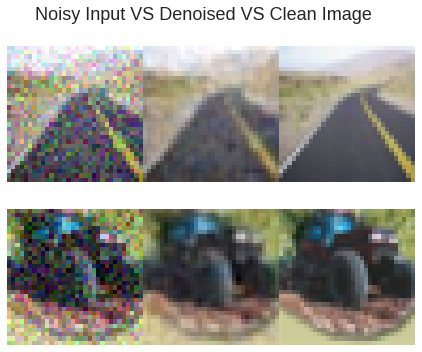

In [0]:
idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = skip_model.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0 
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Denoised VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col
    
    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])

Images are a bit blurry, but noise is almost all gone! 

# UNet Architecture

UNet is an autoencoder architecture with skip connections between encoder and decoder. It is a widely used architecture in the computer vision community for denoising images since its capability and connections allow it to learn to remove the noise from images really effectively.

Let's define first of all the model:


In [0]:
from keras.layers import MaxPooling2D, Dropout


def UNet_model():
  
  inputs = Input((32,32,3))
  
  ## Encoder part
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  drop4 = Dropout(rate=0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  drop5 = Dropout(rate=0.5)(conv5)

  ## Now the decoder starts
  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv10 = Conv2D(3, 3,  padding = 'same')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  
  return model

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_210 (Conv2D)          (None, 16, 16, 32)        896       
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_212 (Conv2D)          (None, 4, 4, 128)         73856     
_________________________________________________________________
conv2d_213 (Conv2D)          (None, 4, 4, 64)          73792     
_________________________________________________________________
up_sampling2d_85 (UpSampling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_214 (Conv2D)          (None, 8, 8, 32)          18464     
_________________________________________________________________
up_sampling2d_86 (UpSampling (None, 16, 16, 32)        0         
__________

Note that instead of using stride of 2 as done in previous architectures, UNet uses maxpooling. You can try to use maxpooling in previous models and see what gives you the best result. 

Let's train UNet model:

In [0]:
unet = UNet_model()
unet.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mse'])
unet.fit(x_train_noise, x_train, batch_size=128, epochs=10, validation_split=0.1)

_, mse = unet.evaluate(x_test_noise, x_test)

print('UNet Model MSE: ', mse)

Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 100s 2ms/step - loss: 0.3200 - mean_squared_error: 38.0305 - val_loss: 0.0368 - val_mean_squared_error: 0.0023
Epoch 2/10
45000/45000 [==============================] - 95s 2ms/step - loss: 0.0356 - mean_squared_error: 0.0022 - val_loss: 0.0347 - val_mean_squared_error: 0.0021
Epoch 3/10
45000/45000 [==============================] - 95s 2ms/step - loss: 0.0340 - mean_squared_error: 0.0020 - val_loss: 0.0332 - val_mean_squared_error: 0.0019
Epoch 4/10
45000/45000 [==============================] - 95s 2ms/step - loss: 0.0331 - mean_squared_error: 0.0019 - val_loss: 0.0326 - val_mean_squared_error: 0.0018
Epoch 5/10
45000/45000 [==============================] - 95s 2ms/step - loss: 0.0324 - mean_squared_error: 0.0018 - val_loss: 0.0318 - val_mean_squared_error: 0.0018
Epoch 6/10
45000/45000 [==============================] - 95s 2ms/step - loss: 0.0319 - mean_squared_error: 0.0018

Finally, we can visualize the final denoised images:

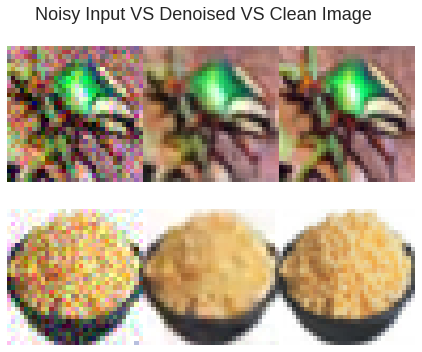

In [0]:
idx_example = np.random.randint(0, len(x_test_noise))
x_test_denoised = unet.predict(x_test_noise[idx_example:idx_example+2, ...])

N=2
start_val = 0 
fig, axes = plt.subplots(N,1)
plt.suptitle('Noisy Input VS Denoised VS Clean Image', fontsize=18)
for row in range(N):
  for col in range(1):
    idx = start_val+row+N*col
    
    im = np.concatenate((x_test_noise[idx_example+idx], x_test_denoised[idx], x_test[idx_example+idx]), 1)
    axes[row].imshow(np.clip(im, 0, 1))
    axes[row].set_xticks([])
    axes[row].set_yticks([])